In [2]:
# Install talib (technical indicators)
# %%capture будет подавлять весь вывод - эти команды производят слишком много выходных сигналов
'''
%capture
! wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
! tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!sudo make install
!sudo apt upgrade
!pip3 install ta-lib
''';

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,3)
plt.style.use("ggplot")
import pandas as pd
pd.set_option("display.max_rows",15)
import numpy as np
import seaborn as sns
import plotly as py
import plotly.graph_objects as go
import math
import talib
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPool2D, AveragePooling2D, add, concatenate
from tensorflow.keras import Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
#file_path = '/content/drive/My Drive/Forex_AI/'

/home/artem/.local/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



Будет использована структура для кодирования временных рядов в виде различных типов
изображений, а именно *Грамианы углового суммирования / поля разниц* `Gramian Angular Summation/Difference Fields (GASF/GADF)` и *переходные поля Маркова* `Markov Transition Fields (MTF)`. Это позволяет использовать
методы компьютерного зрения для временных рядов. 

> Использование плиточных сверточных нейронных сетей `Tiled Convolutional Neural Networks (tiled CNNs)` на 20 стандартных наборов данных, для изучения высокоуровневых признаков показали очень конкурентоспособные результаты по сравнению с девятью нынешними лучшими подходами к классификации временных рядов.
Временные данные (даты) масштабируются в период {0/1}, это даёт  на тесте MSE 12,18%-48,02% при сравнении
с необработанными данными.

#### Две структуры для кодирования временных рядов в виде изображения. ######
Первый тип изображения - 
>Грамианское угловой поле `Gramian Angular Field (GAF)`, в котором временные ряды представляются в полярной системе координат вместо типичной декартовой.
<br>В Грамиевой матрице каждый элемент фактически является косинусом суммы углов.

Марковское переходное поле `Markov Transition Field  (MTF)` заключается в построении Марковской
матрицы квантильных бинов после дискретизации и кодирования вероятности динамического перехода в квазигремиевой матрице.

#### Gramian Angular Field #### 

В этом методе временной ряд сначала преобразуется в полярные координаты, где радиус представляет временные метки, а косинус угла представляет амплитудные значения в данных, масштабированных в интервале [-1,1] или [0,1]. Здесь мы использовали диапазон [-1,1], и значения arccos в этом диапазоне соответствуют угловым значениям в диапазоне [0, π], который позже используется при расчете детализации информации в гаф. 

<img src='https://user-images.githubusercontent.com/54672403/84806620-a4d9f680-b00e-11ea-98da-4ce20373f90c.png'>
Имея временной ряд $X = {x1, x2,..., xn}$ из n вещественных наблюдений, мы масштабируем X так, чтобы все значения попадали в интервал $[−1, 1]$ или $[0, 1]$


$$ x̃^i_{−1} = \frac{(xi−max(X)+(xi−min(X))}{max(X)−min(X)}$$

$$ x̃^i_{0} = \frac{xi−min(X)}{max(X)−min(X)}$$

Далее угол Косинуса  $\phi_i$  вычисляется с помощью временной метки, как:

$$
\begin{equation}
    \begin{matrix}
      \left\{
       \begin{matrix}
           φ = arccos ( \bar{x}_i ),& −1 ≤ x̃_i ≤ 1,& x̃_i ∈ \bar{X} \\
           r = \frac{t_i}{N},& t_i ∈ N
        \end{matrix}
       \right.
    \end{matrix}
\end{equation}
$$

Радиус задается $r=\frac{t_i}{N}$, где  $ti$ является временной меткой, а N - постоянным фактором для регуляции промежутка полярной системы координат.

Масштабируемые данные в разных интервалах имеют разный угол наклона границы.
<br> [0, 1] соответствует косинусной функции в промежутке [0, π/2 ], в то время как значения косинусов в интервале [-1, 1] попадают в  [0, π]. 

> После преобразования масштабированного временного ряда к полярной системе координат, мы можем легко использовать угловую перспективу, рассматривая тригонометрическую сумму / разницу между
каждой точкой идентифицируя временную корреляцию в пределах различных временных интервалов. 

Грамианово угловое поле суммирования `Gramian Summation Angular Field` (GASF) и Грамианово угловое поле разницы  `Gramian Difference Angular Field ` (GADF)

`Gramian Angular Summation Field (GASF)` формируется с помощью тригонометрического суммирования угла заданного обратным Косинусом в масштабируемом сигнале временного ряда следующим образом:

$$GASF=\begin{pmatrix}
cos(\phi_1+\phi_1)&\dots &cos(\phi_1+\phi_n)\\
\dots & \dots & \dots\\
cos(\phi_n+\phi_1)&\dots &cos(\phi_n+\phi_n)
\end{pmatrix}$$

$$ GASF = [\cos(φ_i + φ_j )] = \bar{X}’ · \bar{X} − \sqrt{I − \bar{X}^2}’ · \sqrt{I − \bar{X}^2} $$

Использование тригонометрической разности углов вместо суммирования привело бы к образованию `GADF`:

$$ GADF = [\sin(φ_i + φ_j )] =  \sqrt{I − \bar{X}^2}’ · \bar{X} - \bar{X} ’ ·  \sqrt{I − \bar{X}^2} $$

$I$-единичный вектор [1, 1, ..., 1]. 
<br>После преобразования в полярную систему координат,  мы принимаем временные ряды в каждый момент времени шага как 1-D мерное пространство.

<font color='blue'>
##### Иллюстрация, как данные временных рядов могут быть встроены в изображения с помощью двух различных методов:
</font>
<br> а) рекуррентные графики `Recurrence Plots (RP)` 
<br>Б) Грамианово угловое поле  `Gramian Angular Field (GAF)`


In [2]:
## piecewise aggregate approximation
def paa(data,ds_factor=2):
    '''
    Кусочно-агрегатное приближение
    
    data ( DxN ndarray) d-количество серий, n-количество образцов в каждой серии
    ds_factor (int)   downsampling factor, default is 2
    
    return:
      ds_series (ndarray) downsampled time series
    '''
    d,ds_b = data.shape
    ds_length = int(ds_b/ds_factor)
    ds_series = np.empty(shape = (d,ds_length))
    for i in range (ds_length):
        ds_series[:,i] = np.mean(data[:,i*ds_factor:(i+1)*ds_factor],axis=1)
    return ds_series

## rescaling series into range [0,1]
def rescale(data):
    '''
    Масштабирование серии в диапазон [0,1]
    
    data ( DxN ndarray) d-количество серий, n-количество образцов в каждой серии
    
    return:  rescaled ( DxN ndarray)
    
    '''
    num=data-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    denom=np.tile(np.mat(data.max(axis=1)).T,(1,np.shape(data)[1]))-np.tile(np.mat(data.min(axis=1)).T,(1,np.shape(data)[1]))
    rescaled=np.multiply(num,1/denom)
    return rescaled

## визуализация временных рядов как unthresholded recurrence plot (RP)
def r_plot(data,delay=0):
    '''
    data (ndarray 1xn), n - количество образцов в каждой серии
    delay (int)  delay embedding for RP formation, default = 1
    
    return : rp (NxN ndarray), unthresholded recurrence plot for series
    '''
    transformed = np.zeros([2,len(data)-delay])
    transformed[0,:] = data[0:len(data)-delay]
    transformed[1,:] = data[delay:len(data)]
    rp = np.zeros([len(data)-delay,len(data)-delay])
    for i in range(len(rp)):
        temp = np.tile(transformed[:,i],(len(rp),1)).T-transformed
        temp2 = np.square(temp)
        rp[i,:] = np.sum(temp2,axis=0)
    return np.array(rp)



## визуализация временных рядов как Gramian Angular Difference Field (GADF)
def polar_rep(data):
    '''
    data (1xn ndarray) n-количество образцов в каждой серии
    
    return: phi (1xn ndarray)
            r   (1xn ndarray)
    '''
    phi=np.arccos(data)
    r=(np.arange(0,np.shape(data)[1])/np.shape(data)[1])+0.1
    return phi,r
    
def GADF(data):
    '''
    data (1xN ndarray) N-количество образцов в каждой серии
    
    return: gadf (NxN ndarray) GADF для серии
    '''
    datacos = np.array(data)
    datasin = np.sqrt(1-datacos**2)
    gadf = datasin.T*datacos-datacos.T*datasin
    return gadf

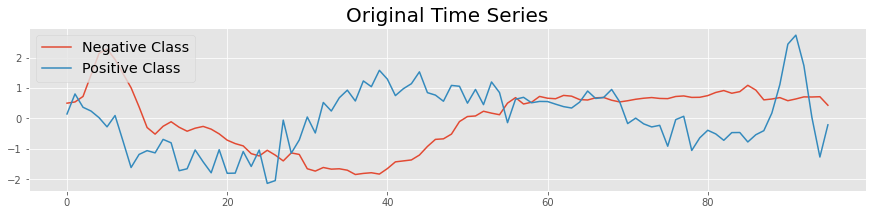

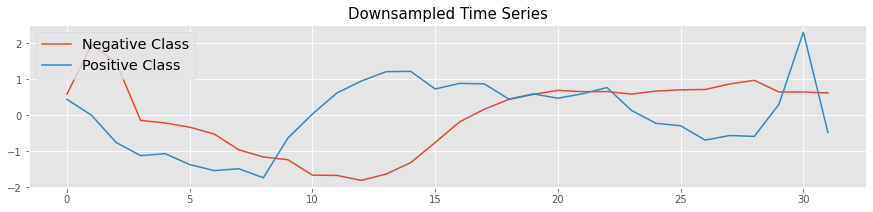

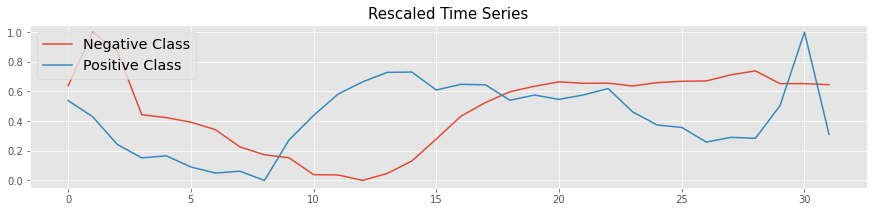

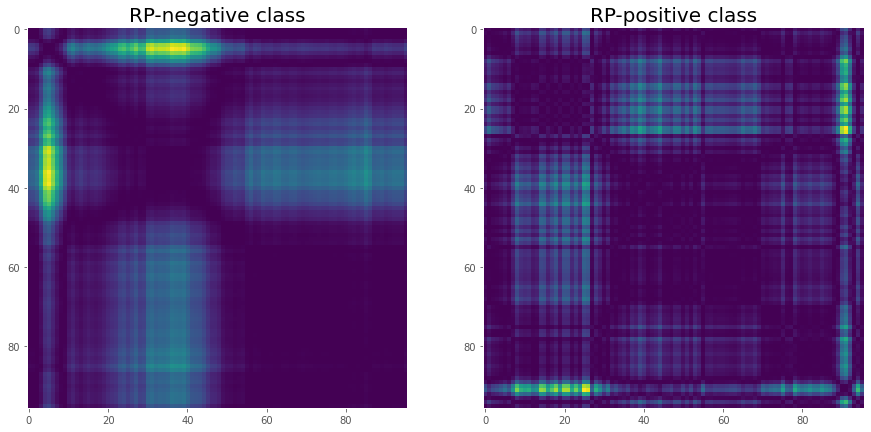

In [5]:
train_np = pd.read_csv('train.tsv', sep="\t", header=None, usecols=np.arange(1,97)).to_numpy()
test_np  = pd.read_csv('test.tsv', sep="\t", header=None, usecols=np.arange(1,97)).to_numpy()

train_labels= pd.read_csv('train.tsv', sep="\t", header=None, usecols=[0]).to_numpy()
test_labels = pd.read_csv('test.tsv', sep="\t", header=None, usecols=[0]).to_numpy()

toy_data=train_np[[0,1],:]
plt.plot(toy_data[0])
plt.plot(toy_data[1])
plt.legend(['Negative Class','Positive Class'],
  fontsize="x-large", loc='upper left')
plt.title('Original Time Series', size=20)

## downsampling
ds_data=paa(toy_data,3)
plt.figure()
plt.plot(ds_data[0])
plt.plot(ds_data[1])
plt.legend(['Negative Class','Positive Class'],
  fontsize="x-large", loc='upper left')
plt.title('Downsampled Time Series', size=15)

## rescaling
rescaled=rescale(ds_data)
plt.figure()
plt.plot(rescaled[0].T)
plt.plot(rescaled[1].T)
plt.legend(['Negative Class','Positive Class'],
  fontsize="x-large", loc='upper left')
plt.title('Rescaled Time Series', size=15);

## Recurrence Plots  
RP=[]
for i in range(2):
    RP.append(r_plot(toy_data[i]))
_,(ax1, ax2)=plt.subplots(1,2,figsize=(15, 8))
ax1.imshow(RP[0]), ax1.grid(False)
ax1.set_title('RP-negative class', size=20);
ax2.imshow(RP[1]), ax2.grid(False)
ax2.set_title('RP-positive class', size=20);

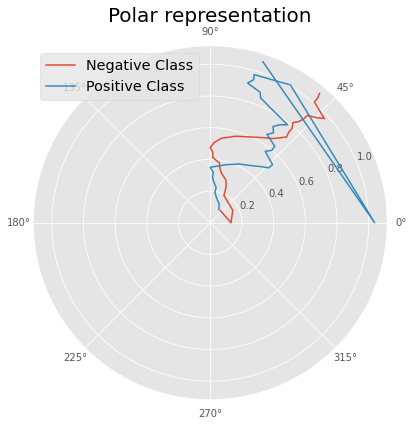

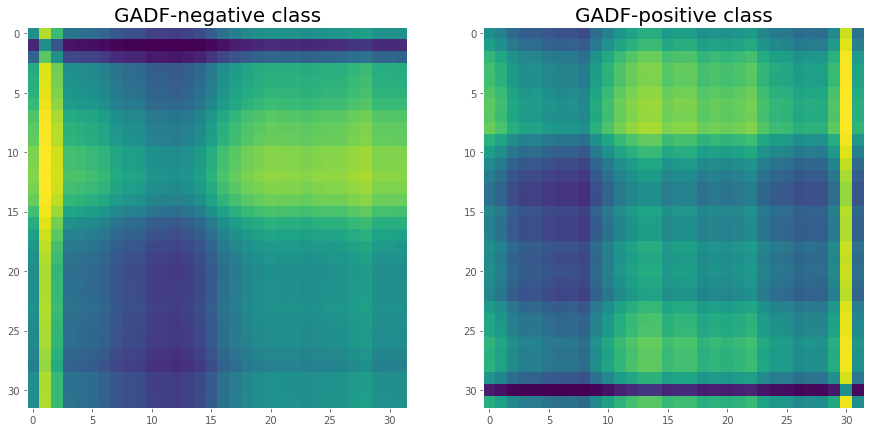

In [6]:
### Gramian Angular Difference Field (GADF) ###
## polar embedding
phi_neg,r_neg=polar_rep(rescaled[0])
phi_pos,r_pos=polar_rep(rescaled[1])

plt.figure(figsize=(11, 6))
plt.polar(np.ravel(phi_neg),r_neg)
plt.polar(np.ravel(phi_pos),r_pos)
plt.legend(['Negative Class','Positive Class'], 
 fontsize="x-large", loc='upper left')
plt.title('Polar representation', size=20)
plt.tight_layout()

## GADF embedding
GADF_i=[]
for i in range(2):
    GADF_i.append(GADF(rescaled[i]))
    
_,(ax1, ax2)=plt.subplots(1,2,figsize=(15, 8))
ax1.imshow(GADF_i[0]), ax1.grid(False)
ax1.set_title('GADF-negative class', size=20);
ax2.imshow(GADF_i[1]), ax2.grid(False)
ax2.set_title('GADF-positive class', size=20);

In [8]:
## Generating RP and GADF images for ECG200
train_ds = paa(train_np,3)
test_ds  = paa(test_np,3)
train_img_rp = np.empty(shape=(len(train_ds),32,32))
test_img_rp  = np.empty(shape=(len(test_ds),32,32))

for i in range(len(train_ds)):
    train_img_rp[i,:,:]=r_plot(train_ds[i,:])
for i in range(len(test_ds)):  
    test_img_rp[i,:,:]=r_plot(test_ds[i,:])
print("Generated RP images")


train_rs=rescale(train_ds)
test_rs = rescale(test_ds)
train_img_gadf = np.empty(shape=(len(train_rs),32,32))
test_img_gadf  = np.empty(shape=(len(test_rs),32,32))

for i in range(len(train_rs)):
    train_img_gadf[i,:,:]=GADF(train_rs[i])
for i in range(len(test_ds)):  
    test_img_gadf[i,:,:]=GADF(test_rs[i])
print("Generated GADF images")

Generated RP images
Generated GADF images


**Архитектура:** двухлойная СNN 32(5)-2-32(5)-2-128-С.
<br>Это означает, что существует два свёрточных слоя с размером фильтра `32` и размером ядра `5 х 5`.
За сверточным слоем следует слой `maxPooling 2 X 2` и слой `Dropout 0.25`. Полно-связанный слой содержит `128` скрытых нейронов, за которыми следует `Dropout 0,5`.
<br>- `"С"` Здесь относится к числу классов.
<br>**Активация:** ReLU
<br>**Функция потерь:** категориальная перекрестная энтропия
<br>**Оптимизатор:** Адам

In [9]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils import plot_model
from keras import optimizers

### set-up a default CNN
def CNN(train_img,test_img,train_labels, test_labels, batch_size=10, num_classes=2, epochs=500):

    ## input image
    img_rows, img_cols = 32,32
    (x_train, y_train), (x_test, y_test) = (train_img, train_labels), (test_img, test_labels)
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test  =  x_test.reshape(x_test.shape[0],  img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    def labeling(y,num_classes):
      from sklearn.preprocessing import LabelEncoder
      encoder = LabelEncoder()
      encoder.fit(y)
      encoded_Y = encoder.transform(y)
      ## one-hot-encode
      dummy_y = keras.utils.np_utils.to_categorical(encoded_Y,num_classes)
      return(dummy_y)

    #from keras.utils.np_utils import to_categorical
    y_train = labeling(np.ravel(y_train), num_classes)
    y_test  = labeling(np.ravel(y_test), num_classes)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, kernel_size=(3,3), 
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    history=model.fit(x_train, y_train,
              batch_size,
              epochs,
              verbose=0,
              validation_data=(x_test, y_test))
    return history

Using TensorFlow backend.


x_train shape: (100, 32, 32, 1)
100 train samples
100 test samples
max. Validation accuracy: 94.00%
max. Training accuracy: 100.00%


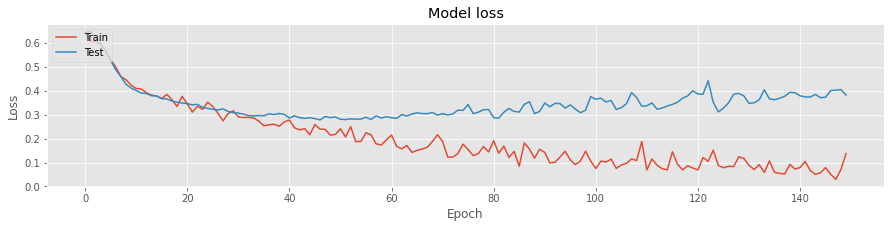

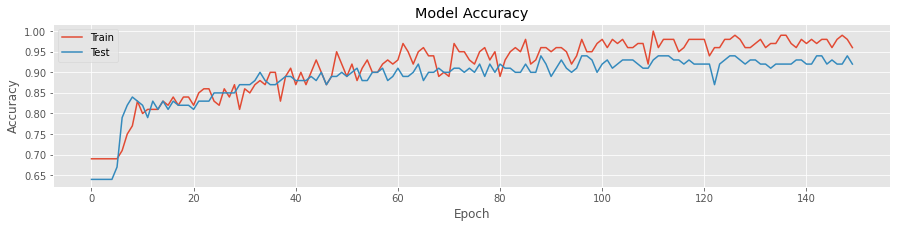

In [10]:
### Train - RP images
history=CNN(train_img_rp,test_img_rp,train_labels, test_labels,epochs=150)
print("max. Validation accuracy: {:.2%}".format( max(history.history['val_accuracy'])))
print("max. Training accuracy: {:.2%}".format( max(history.history['accuracy'])))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

x_train shape: (100, 32, 32, 1)
100 train samples
100 test samples
max. Validation accuracy: 88.00%
max. Training accuracy: 98.00%


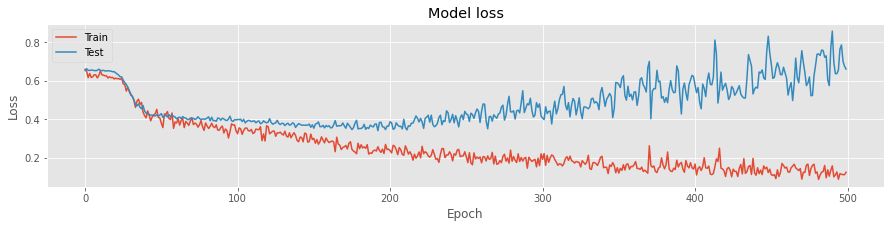

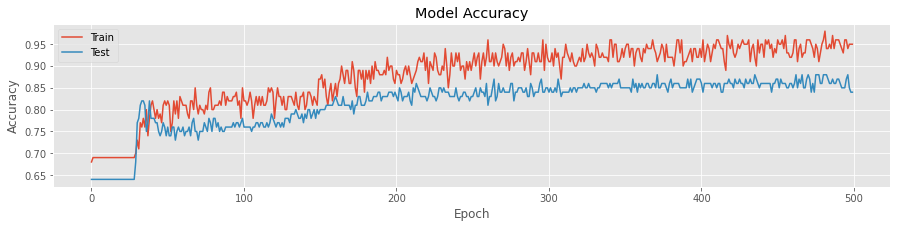

In [11]:
### Training - GADF images
history=CNN(train_img_gadf,test_img_gadf,train_labels, test_labels,epochs=500)
print("max. Validation accuracy: {:.2%}".format( max(history.history['val_accuracy'])))
print("max. Training accuracy: {:.2%}".format( max(history.history['accuracy'])))


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<img src='https://user-images.githubusercontent.com/54672403/84806917-1d40b780-b00f-11ea-9c51-4786f551de71.png'>

Иллюстрация предложенной кодирующей карты Марковских переходных полей `Markov Transition Fields`. 
<br> X-это последовательность временных рядов в набор данных "EGC".
<br>X сначала дискретизируется в  Q quantile bins
Затем мы вычисляем его Марковскую переходную матрицу W и, наконец, строим его MTF
применяем `Piecewise Aggregation Approximation (PAA)` чтобы сгладить временные ряды
для сохранении тенденций.

####  Markov Transition Field


Дан временной ряд X, то определить его Q quantile bins и
назначьте каждому $x_i,  соответствующие ячейки  q_j (j ∈ [1, Q])$

Таким образом мы строим Q×Q взвешенную матрицу смежности W путем подсчета переходов между квантильными ячейками в виде Марковской цепи первого порядка вдоль оси времени. 
$w_{i, j}$ задается частотой, с которой точка в квантиле qj следует точка в квантиле qi
После нормализации W становится матрицей перехода Маркова

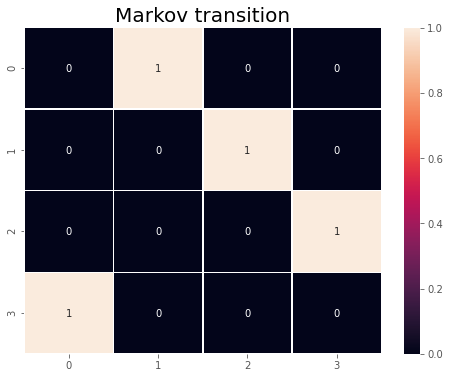

In [7]:
'''
Cледующий код принимает такой список, как
[1,1,2,6,8,5,5,7,8,8,1,1,4,5,5,0,0,0,1,1,4,4,5,1,3,3,4,5,4,1,1]
с состояниями, помеченными как последовательные целые числа,
начинающиеся с 0 и возвращает матрицу перехода Маркова,
где M[i][j] - вероятность перехода от i к j
'''

def transition_matrix(transitions):
    n = 1+ max(transitions) #число состояний

    M = [[0]*n for _ in range(n)]

    for (i,j) in zip(transitions,transitions[1:]):
        M[i][j] += 1

    ## преобразование в вероятности:
    for row in M:
        s = sum(row)
        if s > 0:
            row[:] = [f/s for f in row]
    return M

t = [0,1,2,3, 0,1,2,3, 0,1,2,3, 0,1,2,3, 0,1,2,3, 0,1,2,3, 0,1,2,3, 0,1,2,3]
#t = [1,1,2,6, 8,5,5,7, 8,8,1,1, 4,5,5,0, 0,0,1,1, 4,4,5,1, 3,3,4,5, 4,1,1]
m = transition_matrix(t)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(m, annot=True, linewidths=.5)
ax.set_title('Markov transition', size=20)
plt.show()

Мы строим матрицу перехода Q × Q Маркова (W), разделяя данные на Q квантильных ячеек. Квантиль
ячейки, содержащие данные на отметках времени i и j (временная ось)
являются qi и qj (q ∈ [1, Q]). $M_{ij}$ в MTF обозначает вероятность перехода qi → qj . То есть мы разложили матрицу W которая содержит вероятность перехода на величину ось в матрицу MTF с учетом временных положений.

Путем присвоения вероятности из квантиля на временном шаге I к квантилю на временном шаге j на каждом пикселе $M_{ij}$, MTF на самом деле кодирует multi-span переходных вероятностей

#### Cтруктура плиточной сверточных нейронных сетей.
<img src='https://user-images.githubusercontent.com/54672403/84812981-eb801e80-b017-11ea-894b-0c7c40c80892.png'>
Мы фиксируем размер рецептивных полей `receptive fields` до 8×8 в первом сверточном слое и 3×3 во втором сверточном слое.

Каждый объединяющий слой TICA объединяет блоки размером 3×3
в предыдущем слое без деформации по краям, для оптимизации разреженности блоков объединения.

Последний слой-это linear SVM для классификации. Мы строим эту сеть путем укладки двух плиточных CNN


<img src='https://user-images.githubusercontent.com/54672403/84817561-d8704d00-b01d-11ea-86a2-82f93d1ea4d6.png'>

<img src='https://user-images.githubusercontent.com/54672403/84818025-81b74300-b01e-11ea-9b25-dc8bb73263ba.png'>

In [2]:
'''### data [1H] pre-process https://www.kaggle.com/imetomi/eur-usd-forex-pair-historical-data-2002-2019###
file_path = '/home/artem/Desktop/python_lern/HardCode/movieclassifier/bundle_archive/'
df =pd.read_csv(file_path+'eurusd_hour.csv')
df['Date'] = df['Date'].str.cat(df['Hour'], sep =" ")
df.drop('Hour', axis=1, inplace=True)
df.to_csv('eurusd_hour.csv', index=False)
'''
'''### data [1M] pre-process https://www.kaggle.com/imetomi/eur-usd-forex-pair-historical-data-2002-2019###
df = pd.read_csv(file_path+'eurusd_minute.csv')
df = df.iloc[-380000:] # [15M]2018~2019 (1y) 
df['Hour']  = (df[['Minute']]//60).applymap(int).applymap(str)
df['Minute']= (df[['Minute']]%60).applymap(int).applymap(str)
df['Date']= df['Date'].str.cat(df[['Hour']], sep =" ")
df['Date']= df['Date'].str.cat(df[['Minute']], sep =":")
df.drop(['Minute', 'Hour'], axis=1, inplace=True)
df.to_csv('eurusd_minute.csv', index=False)
''';

### Read  data


In [4]:
'''### [1M](2018) data-frame ###
df =pd.read_csv('data/eurusd_minute.csv')
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M')
df.drop_duplicates(subset=df.columns.difference(['Date']), keep=False, inplace=True)
df
''';

In [5]:
### [1H](2005-2019) data-frame ###
df =pd.read_csv('data/eurusd_hour.csv').iloc[1000:] # В начале мало данных
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d %H:%M:%S')
df.drop_duplicates(subset=df.columns.difference(['Date']), keep=False, inplace=True)
df

,Date,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange
1000,2005-01-11 06:00:00,1.31285,1.31355,1.31135,1.31185,0.00100,1.31305,1.31375,1.31155,1.31205,0.00100
1001,2005-01-11 07:00:00,1.31175,1.31460,1.31135,1.31325,-0.00150,1.31195,1.31475,1.31155,1.31340,-0.00145
1002,2005-01-11 08:00:00,1.31325,1.31405,1.31195,1.31235,0.00090,1.31340,1.31420,1.31210,1.31250,0.00090
1003,2005-01-11 09:00:00,1.31235,1.31510,1.31157,1.31430,-0.00195,1.31250,1.31525,1.31172,1.31445,-0.00195
1004,2005-01-11 10:00:00,1.31430,1.31710,1.31420,1.31590,-0.00160,1.31445,1.31725,1.31435,1.31605,-0.00160
1005,2005-01-11 11:00:00,1.31590,1.31665,1.31530,1.31650,-0.00060,1.31605,1.31680,1.31545,1.31665,-0.00060
1006,2005-01-11 12:00:00,1.31640,1.31700,1.31435,1.31465,0.00175,1.31655,1.31715,1.31450,1.31480,0.00175
...,...,...,...,...,...,...,...,...,...,...,...
90225,2019-01-18 17:00:00,1.13613,1.13630,1.13559,1.13576,0.00037,1.13626,1.13642,1.13571,1.13589,0.00037
90226,2019-01-18 18:00:00,1.13577,1.13681,1.13576,1.13650,-0.00073,1.13591,1.13693,1.13588,1.13664,-0.00073


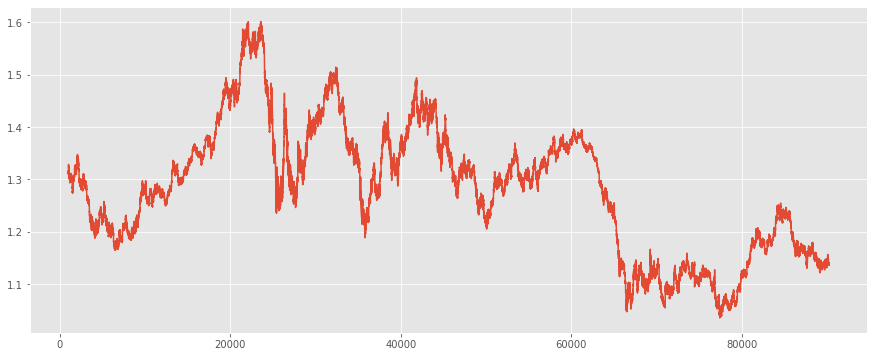

In [6]:
'''
fig = go.Figure(data=go.Ohlc(x=df['Date'],
                open=df['BidOpen'],
                high=df['BidHigh'],
                low=df['BidLow'],
                close=df['BidClose']))
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()
'''
plt.figure(figsize=(15,6))
plt.plot(df.AskClose)
plt.show()

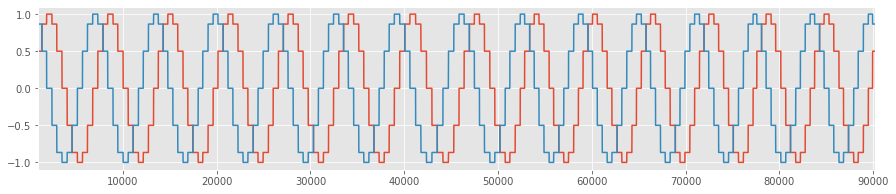

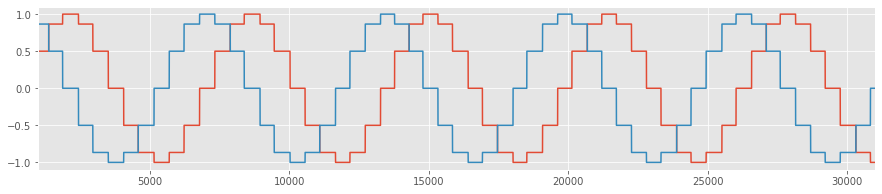

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange,sin_hour,cos_hour,sin_day,cos_day,sin_month,cos_month
1000,1.31285,1.31355,1.31135,1.31185,0.00100,1.31305,1.31375,1.31155,1.31205,0.00100,1.000000e+00,6.123234e-17,-0.433884,-0.900969,0.5,0.866025
1001,1.31175,1.31460,1.31135,1.31325,-0.00150,1.31195,1.31475,1.31155,1.31340,-0.00145,9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
1002,1.31325,1.31405,1.31195,1.31235,0.00090,1.31340,1.31420,1.31210,1.31250,0.00090,8.660254e-01,-5.000000e-01,-0.433884,-0.900969,0.5,0.866025
1003,1.31235,1.31510,1.31157,1.31430,-0.00195,1.31250,1.31525,1.31172,1.31445,-0.00195,7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.5,0.866025
1004,1.31430,1.31710,1.31420,1.31590,-0.00160,1.31445,1.31725,1.31435,1.31605,-0.00160,5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.5,0.866025
1005,1.31590,1.31665,1.31530,1.31650,-0.00060,1.31605,1.31680,1.31545,1.31665,-0.00060,2.588190e-01,-9.659258e-01,-0.433884,-0.900969,0.5,0.866025
1006,1.31640,1.31700,1.31435,1.31465,0.00175,1.31655,1.31715,1.31450,1.31480,0.00175,1.224647e-16,-1.000000e+00,-0.433884,-0.900969,0.5,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90225,1.13613,1.13630,1.13559,1.13576,0.00037,1.13626,1.13642,1.13571,1.13589,0.00037,-9.659258e-01,-2.588190e-01,-0.433884,-0.900969,0.5,0.866025
90226,1.13577,1.13681,1.13576,1.13650,-0.00073,1.13591,1.13693,1.13588,1.13664,-0.00073,-1.000000e+00,-1.836970e-16,-0.433884,-0.900969,0.5,0.866025


In [7]:
# Добавление {часов, дней недель и месяцов года} (для доп функций)
# Используется синус и косинус, чтобы сохранить циклическую натуру {часа, дня и месяца}
df['sin_hour'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
df['sin_day']  = np.sin(2 * np.pi * df['Date'].dt.day / 7)
df['cos_day']  = np.cos(2 * np.pi * df['Date'].dt.day / 7)
df['sin_month'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

## Удаление столбеца даты (он больше не нужен)
df.drop('Date', axis=1, inplace=True)

## Plot чтобы проиллюстрировать циклическую природу времени
df.sin_month.plot()
df.cos_month.plot()
plt.show()
df.iloc[:30000].sin_month.plot()
df.iloc[:30000].cos_month.plot()
plt.show()

## updated dataframe
df

In [160]:
# Добавление технических индикаторов (для доп. функций)
df['Bid_SMA1'] = talib.SMA(df['BidClose'], timeperiod=10)
df['Bid_SMA1_Envelope_Upper'] = df['Bid_SMA1'] + (0.1 * df['Bid_SMA1'])
df['Bid_SMA1_Envelope_Lower'] = df['Bid_SMA1'] - (0.1 * df['Bid_SMA1'])
df['Bid_EMA1'] = talib.EMA(df['BidClose'], timeperiod=10)
df['Bid_EMA1_Envelope_Upper'] = df['Bid_EMA1'] + (0.1 * df['Bid_EMA1'])
df['Bid_EMA1_Envelope_Lower'] = df['Bid_EMA1'] - (0.1 * df['Bid_EMA1'])
df['Bid_SMA2'] = talib.SMA(df['BidClose'], timeperiod=20)
df['Bid_SMA2_Envelope_Upper'] = df['Bid_SMA2'] + (0.1 * df['Bid_SMA2'])
df['Bid_SMA2_Envelope_Lower'] = df['Bid_SMA2'] - (0.1 * df['Bid_SMA2'])
df['Bid_EMA2'] = talib.EMA(df['BidClose'], timeperiod=20)
df['Bid_EMA2_Envelope_Upper'] = df['Bid_EMA2'] + (0.1 * df['Bid_EMA2'])
df['Bid_EMA2_Envelope_Lower'] = df['Bid_EMA2'] - (0.1 * df['Bid_EMA2'])
df['Bid_SMA3'] = talib.SMA(df['BidClose'], timeperiod=30)
df['Bid_SMA3_Envelope_Upper'] = df['Bid_SMA3'] + (0.1 * df['Bid_SMA3'])
df['Bid_SMA3_Envelope_Lower'] = df['Bid_SMA3'] - (0.1 * df['Bid_SMA3'])
df['Bid_EMA3'] = talib.EMA(df['BidClose'], timeperiod=30)
df['Bid_EMA3_Envelope_Upper'] = df['Bid_EMA3'] + (0.1 * df['Bid_EMA3'])
df['Bid_EMA3_Envelope_Lower'] = df['Bid_EMA3'] - (0.1 * df['Bid_EMA3'])
df['Bid_BB_Upper_Band'], df['Bid_BB_Middle_Band'], df['Bid_BB_Lower_Band'] = talib.BBANDS(
    df['BidClose'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Bid_MACD'], df['Bid_MACD_Signal'], df['Bid_MACD_hist'] = talib.MACD(df['BidClose'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Bid_Parabollic_SAR'] = talib.SAR(df['BidHigh'], df['BidLow'], acceleration=0.02, maximum=0.2)
df['Bid_Slowk'], df['Bid_Slowd'] = talib.STOCH(df['BidHigh'], df['BidLow'], df['BidClose'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Bid_RSI'] = talib.RSI(df['BidClose'], timeperiod=14)
df['Bid_Williams_Percent_Range'] = talib.WILLR(df['BidHigh'], df['BidLow'], df['BidClose'],
                                           timeperiod=14)
df['Bid_ADX'] = talib.ADX(df['BidHigh'], df['BidLow'], df['BidClose'], timeperiod=14)
df['Bid_ADXR'] = talib.ADXR(df['BidHigh'], df['BidLow'], df['BidClose'], timeperiod=14)
df['Bid_MOM'] = talib.MOM(df['BidClose'], timeperiod=10)
df['Bid_BOP'] = talib.BOP(df['BidOpen'], df['BidHigh'], df['BidLow'], df['BidClose'])
df['Bid_AROONOSC'] = talib.AROONOSC(df['BidHigh'], df['BidLow'], timeperiod=14)
df['Bid_ATR'] = talib.ATR(df['BidHigh'], df['BidLow'], df['BidClose'], timeperiod=14)

# Ask technical indicators
df['Ask_SMA1'] = talib.SMA(df['AskClose'], timeperiod=10)
df['Ask_SMA1_Envelope_Upper'] = df['Ask_SMA1'] + (0.1 * df['Ask_SMA1'])
df['Ask_SMA1_Envelope_Lower'] = df['Ask_SMA1'] - (0.1 * df['Ask_SMA1'])
df['Ask_EMA1'] = talib.EMA(df['AskClose'], timeperiod=10)
df['Ask_EMA1_Envelope_Upper'] = df['Ask_EMA1'] + (0.1 * df['Ask_EMA1'])
df['Ask_EMA1_Envelope_Lower'] = df['Ask_EMA1'] - (0.1 * df['Ask_EMA1'])
df['Ask_SMA2'] = talib.SMA(df['AskClose'], timeperiod=20)
df['Ask_SMA2_Envelope_Upper'] = df['Ask_SMA2'] + (0.1 * df['Ask_SMA2'])
df['Ask_SMA2_Envelope_Lower'] = df['Ask_SMA2'] - (0.1 * df['Ask_SMA2'])
df['Ask_EMA2'] = talib.EMA(df['AskClose'], timeperiod=20)
df['Ask_EMA2_Envelope_Upper'] = df['Ask_EMA2'] + (0.1 * df['Ask_EMA2'])
df['Ask_EMA2_Envelope_Lower'] = df['Ask_EMA2'] - (0.1 * df['Ask_EMA2'])
df['Ask_SMA3'] = talib.SMA(df['AskClose'], timeperiod=30)
df['Ask_SMA3_Envelope_Upper'] = df['Ask_SMA3'] + (0.1 * df['Ask_SMA3'])
df['Ask_SMA3_Envelope_Lower'] = df['Ask_SMA3'] - (0.1 * df['Ask_SMA3'])
df['Ask_EMA3'] = talib.EMA(df['AskClose'], timeperiod=30)
df['Ask_EMA3_Envelope_Upper'] = df['Ask_EMA3'] + (0.1 * df['Ask_EMA3'])
df['Ask_EMA3_Envelope_Lower'] = df['Ask_EMA3'] - (0.1 * df['Ask_EMA3'])
df['Ask_BB_Upper_Band'], df['Ask_BB_Middle_Band'], df['Ask_BB_Lower_Band'] = talib.BBANDS(
    df['AskClose'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['Ask_MACD'], df['Ask_MACD_Signal'], df['Ask_MACD_hist'] = talib.MACD(df['AskClose'],
                                                            fastperiod=12,
                                                            slowperiod=26,
                                                            signalperiod=9)
df['Ask_Parabollic_SAR'] = talib.SAR(df['AskHigh'], df['AskLow'], acceleration=0.02, maximum=0.2)
df['Ask_Slowk'], df['Ask_Slowd'] = talib.STOCH(df['AskHigh'], df['AskLow'], df['AskClose'],
                                       fastk_period=5, slowk_period=3,
                                       slowk_matype=0, slowd_period=3,
                                       slowd_matype=0)
df['Ask_RSI'] = talib.RSI(df['AskClose'], timeperiod=14)
df['Ask_Williams_Percent_Range'] = talib.WILLR(df['AskHigh'], df['AskLow'], df['AskClose'],
                                           timeperiod=14)
df['Ask_ADX'] = talib.ADX(df['AskHigh'], df['AskLow'], df['AskClose'], timeperiod=14)
df['Ask_ADXR'] = talib.ADXR(df['AskHigh'], df['AskLow'], df['AskClose'], timeperiod=14)
df['Ask_MOM'] = talib.MOM(df['AskClose'], timeperiod=10)
df['Ask_BOP'] = talib.BOP(df['AskOpen'], df['AskHigh'], df['AskLow'], df['AskClose'])
df['Ask_AROONOSC'] = talib.AROONOSC(df['AskHigh'], df['AskLow'], timeperiod=14)
df['Ask_ATR'] = talib.ATR(df['AskHigh'], df['AskLow'], df['AskClose'], timeperiod=14)

df

,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange,...,Ask_Slowk,Ask_Slowd,Ask_RSI,Ask_Williams_Percent_Range,Ask_ADX,Ask_ADXR,Ask_MOM,Ask_BOP,Ask_AROONOSC,Ask_ATR
1000,1.31285,1.31355,1.31135,1.31185,0.00100,1.31305,1.31375,1.31155,1.31205,0.00100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.454545,NaN,NaN
1001,1.31175,1.31460,1.31135,1.31325,-0.00150,1.31195,1.31475,1.31155,1.31340,-0.00145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.453125,NaN,NaN
1002,1.31325,1.31405,1.31195,1.31235,0.00090,1.31340,1.31420,1.31210,1.31250,0.00090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428571,NaN,NaN
1003,1.31235,1.31510,1.31157,1.31430,-0.00195,1.31250,1.31525,1.31172,1.31445,-0.00195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552408,NaN,NaN
1004,1.31430,1.31710,1.31420,1.31590,-0.00160,1.31445,1.31725,1.31435,1.31605,-0.00160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.551724,NaN,NaN
1005,1.31590,1.31665,1.31530,1.31650,-0.00060,1.31605,1.31680,1.31545,1.31665,-0.00060,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444,NaN,NaN
1006,1.31640,1.31700,1.31435,1.31465,0.00175,1.31655,1.31715,1.31450,1.31480,0.00175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.660377,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90225,1.13613,1.13630,1.13559,1.13576,0.00037,1.13626,1.13642,1.13571,1.13589,0.00037,...,12.841576,12.667770,28.283982,-90.956522,23.998748,22.827268,-0.00331,-0.521127,-28.571429,0.001164
90226,1.13577,1.13681,1.13576,1.13650,-0.00073,1.13591,1.13693,1.13588,1.13664,-0.00073,...,17.228838,13.348489,35.377070,-77.913043,25.225382,23.385461,-0.00306,0.695238,-28.571429,0.001155


In [161]:
%%time
# 3-дневный период анализа - это довольно широкое окно для дневной торговли. 
#   15-минутные интервалы ~~> нам нужно 288 экземпляров, чтобы оглянуть 3 дня.
subset_size = 200

subset = df.iloc[-subset_size:, :].copy()

## Масштабирование каждой колонки в диапазон [-1, 1]
for j in range(subset.shape[1]):
  if not (subset.iloc[:, j].max() <= 1 and subset.iloc[:, j].min() >= -1):
    subset.iloc[:, j] = ((subset.iloc[:, j] - subset.iloc[:, j].max()) +  \
                         (subset.iloc[:, j] - subset.iloc[:, j].min())) / \
                         (subset.iloc[:, j].max() - subset.iloc[:, j].min())
 
## Нахождение матрицы RP перед преобразованием значений в Косинусные дуги
RP = []
for i in range(subset.shape[0]):
  RP_curr_row = []
  for j in range(subset.shape[0]):
    RP_curr_row.append(np.linalg.norm(subset.iloc[i, :] - subset.iloc[j, :]))
  RP.append(RP_curr_row)
RP = np.expand_dims(RP, axis=0)

# arc cosine(для того чтобы найти GASF и GADF)
for j in range(subset.shape[1]):
  for i in range(subset.shape[0]):
    subset.iloc[i, j] = math.acos(subset.iloc[i, j])

subset.tail()

CPU times: user 36.4 s, sys: 272 ms, total: 36.7 s
Wall time: 35.9 s


,BidOpen,BidHigh,BidLow,BidClose,BidChange,AskOpen,AskHigh,AskLow,AskClose,AskChange,...,Ask_Slowk,Ask_Slowd,Ask_RSI,Ask_Williams_Percent_Range,Ask_ADX,Ask_ADXR,Ask_MOM,Ask_BOP,Ask_AROONOSC,Ask_ATR
90227,2.735804,2.735531,2.687783,2.659645,1.571246,2.769563,2.733387,2.687783,2.661813,1.571246,...,2.047359,2.436570,2.067408,1.992593,1.800629,1.829757,1.573576,1.020129,1.860548,1.569662
90228,2.640884,2.784956,2.715197,2.772363,1.570316,2.663526,2.779717,2.717556,2.769831,1.570316,...,1.576518,2.024419,2.180820,2.183698,1.761198,1.839066,1.574946,2.205070,1.860548,1.569685
90229,2.747936,2.925612,2.828346,2.984333,1.570226,2.777485,2.811054,2.681168,2.756983,1.570856,...,1.294022,1.624766,2.159355,2.162289,1.724852,1.865411,1.574636,1.459455,1.860548,1.569726
90230,3.141593,2.873138,2.854687,2.759428,1.571666,2.764370,2.761062,2.708191,2.727694,1.570926,...,1.239442,1.344620,2.106580,2.112105,1.708628,1.904894,1.574366,1.415410,1.860548,1.569742
90231,2.733418,2.838780,2.670334,2.769742,1.570756,2.736942,2.823182,2.661830,2.764642,1.570666,...,1.489241,1.312754,2.148692,2.175097,1.693596,1.897950,1.574036,1.893438,1.860548,1.569788


In [13]:
%%time
GASF = []
GADF = []

for j in range(subset.shape[1]):
  GASF_curr_matrix = []
  GADF_curr_matrix = []
  for i in range(subset.shape[0]):
    GASF_curr_row = []
    GADF_curr_row = []
    for k in range(subset.shape[0]):
      GASF_curr_row.append(math.cos(subset.iloc[i, j] + subset.iloc[k, j]))
      GADF_curr_row.append(math.sin(subset.iloc[i, j] - subset.iloc[k, j]))
    GASF_curr_matrix.append(GASF_curr_row)
    GADF_curr_matrix.append(GADF_curr_row)
  GASF.append(GASF_curr_matrix)
  GADF.append(GADF_curr_matrix)

GASF = np.array(GASF)
GADF = np.array(GADF)

print('GASF shape: ', GASF.shape)
print('GADF shape: ', GADF.shape)
print('RP shape: ',   RP.shape)

image_data = np.append(GASF.reshape((subset_size, subset_size, -1)),
                       GADF.reshape((subset_size, subset_size, -1)), axis=-1)
image_data = np.append(image_data, RP.reshape((subset_size, subset_size, -1)),
                       axis=-1)
print('Final image data shape: ', image_data.shape)

GASF shape:  (86, 200, 200)
GADF shape:  (86, 200, 200)
RP shape:  (1, 200, 200)
Final image data shape:  (200, 200, 173)
CPU times: user 2min 41s, sys: 189 ms, total: 2min 41s
Wall time: 2min 41s


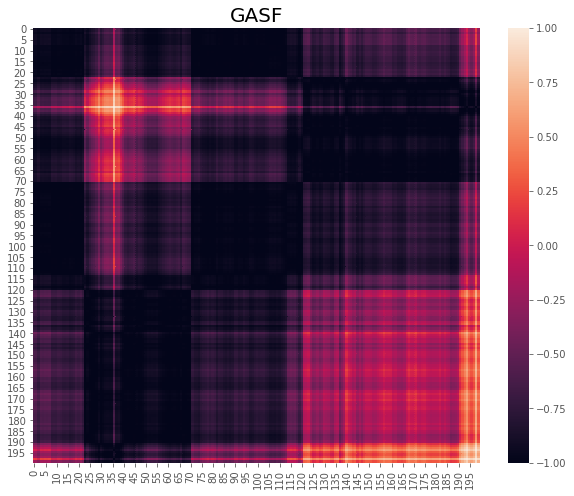

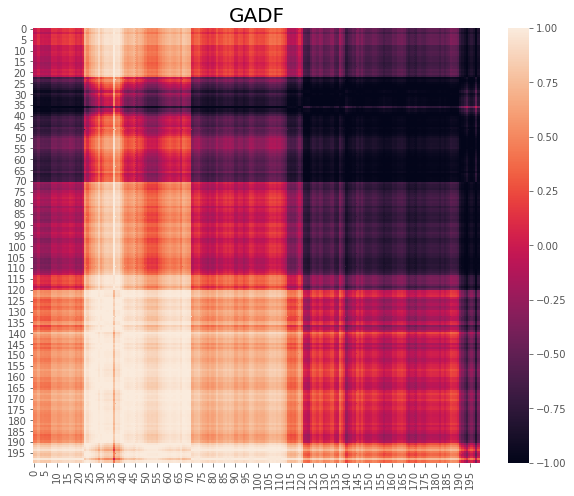

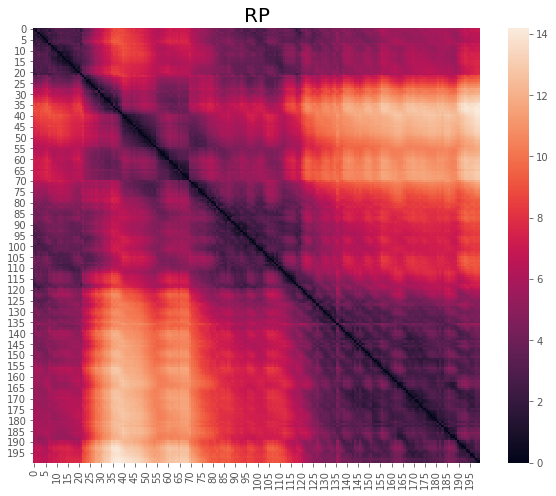

In [163]:
# Plot sample heat maps
plt.figure(figsize=(10, 8))
ax = sns.heatmap(GASF[0])
ax.set_title('GASF', size=20)
plt.show()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(GADF[0])
ax.set_title('GADF', size=20)
plt.show()
plt.figure(figsize=(10, 8))
ax = sns.heatmap(RP[0])
ax.set_title('RP', size=20)
plt.show()

Функция для захвата подмножеств данных (повторное использование кода из предыдущего раздела, но втиснутого в единую функцию)

In [29]:
def grab_image_data(start_index, subset_size=200):
  subset = df.iloc[-subset_size:, :]
    ## Масштабирование каждой колонки в диапазон [-1, 1]

  # Scale each column to be between -1 and 1
  for j in range(subset.shape[1]):
    if not (subset.iloc[:, j].max() <= 1 and subset.iloc[:, j].min() >= -1):
      subset.iloc[:, j] = ((subset.iloc[:, j] - subset.iloc[:, j].max()) + \
                           (subset.iloc[:, j] - subset.iloc[:, j].min())) / \
                           (subset.iloc[:, j].max() - subset.iloc[:, j].min())
  ## Нахождение матрицы RP перед преобразованием значений в Косинусные дуги
  RP = []
  for i in range(subset.shape[0]):
    RP_curr_row = []
    for j in range(subset.shape[0]):
      RP_curr_row.append(np.linalg.norm(subset.iloc[i, :] - subset.iloc[j, :]))
    RP.append(RP_curr_row)
  RP = np.expand_dims(RP, axis=0)
  # arc cosine(для того чтобы найти GASF и GADF)
  for j in range(subset.shape[1]):
    for i in range(subset.shape[0]):

  GASF, GADF = [], []
  for j in range(subset.shape[1]):
    GASF_curr_matrix = []
    GADF_curr_matrix = []

    for i in range(subset.shape[0]):
      GASF_curr_row = []
      GADF_curr_row = []

      for k in range(subset.shape[0]):
        GASF_curr_row.append(math.cos(subset.iloc[i, j] + subset.iloc[k, j]))
        GADF_curr_row.append(math.sin(subset.iloc[i, j] - subset.iloc[k, j]))

      GASF_curr_matrix.append(GASF_curr_row)
      GADF_curr_matrix.append(GADF_curr_row)

    GASF.append(GASF_curr_matrix)
    GADF.append(GADF_curr_matrix)

  GASF = np.array(GASF)
  GADF = np.array(GADF)

  image_data = np.append(GASF.reshape((subset_size, subset_size, -1)),
                         GADF.reshape((subset_size, subset_size, -1)), axis=-1)
  image_data = np.append(image_data, RP.reshape((subset_size, subset_size, -1)),
                        axis=-1)

  return image_data

### IResNet

In [165]:
reduction_factor = 8

def inception_resnet_v2_stem(x):
    ### stride = 2
    x = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = Convolution2D(filters=64//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    ### stride = 2
    a = MaxPool2D(pool_size=(3, 3), strides=1, padding='valid')(x)
    ### stride = 2
    b = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    x = concatenate([a, b], axis=-1)
    
    a = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    a = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(a)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(7, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=64//reduction_factor, kernel_size=(1, 7), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=96//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(b)
    x = concatenate([a, b], axis=-1)
    
    ### stride = 2
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    ### stride = 2
    b = MaxPool2D(pool_size=(3, 3), strides=1, padding='valid')(x)
    x = concatenate([a, b], axis=-1)
    
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_A(x):
    skip_connection = x
    
    a = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=32//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    c = Convolution2D(filters=32//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=48//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    c = Convolution2D(filters=64//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    
    x = concatenate([a, b, c], axis=-1)
    x = Convolution2D(filters=384//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([skip_connection, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_A(x):
    a = MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)
    b = Convolution2D(filters=384//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(x)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(c)
    c = Convolution2D(filters=384//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(c)
    x = concatenate([a, b, c], axis=-1)
    
    return x
    

def inception_resnet_v2_B(x):
    skip_connection = x
    
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=128//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=160//reduction_factor, kernel_size=(1, 7), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=192//reduction_factor, kernel_size=(7, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    x = concatenate([a, b], axis=-1)
    x = Convolution2D(filters=1152//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([skip_connection, x])
    x = Activation('relu')(x)
    
    return x


def inception_resnet_v2_reduction_B(x):
    a = MaxPool2D(pool_size=(3, 3), strides=2, padding='valid')(x)
    b = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(b)
    c = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    c = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(c)
    d = Convolution2D(filters=256//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    d = Convolution2D(filters=288//reduction_factor, kernel_size=(3, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(d)
    d = Convolution2D(filters=320//reduction_factor, kernel_size=(3, 3), strides=2, activation='relu',
                      kernel_initializer='he_normal', padding='valid')(d)
    
    x = concatenate([a, b, c, d], axis=-1)
    
    return x


def inception_resnet_v2_C(x):
    shortcut = x
    
    a = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    
    b = Convolution2D(filters=192//reduction_factor, kernel_size=(1, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(x)
    b = Convolution2D(filters=224//reduction_factor, kernel_size=(1, 3), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    b = Convolution2D(filters=256//reduction_factor, kernel_size=(3, 1), activation='relu',
                      kernel_initializer='he_normal', padding='same')(b)
    
    x = concatenate([a, b], axis=-1)
    x = Convolution2D(filters=2048//reduction_factor, kernel_size=(1, 1), activation='linear',
                      kernel_initializer='he_normal', padding='same')(x)
    
    x = add([shortcut, x])
    x = Activation('relu')(x)
    
    return x

In [166]:
%%time
n_actions = 4
img_rows, img_cols = 200, 200
img_channels = 173

# In the paper these are 5, 10, and 5, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

x = inception_resnet_v2_stem(inputs)
for i in range(num_A_blocks):
    x = inception_resnet_v2_A(x)

x = inception_resnet_v2_reduction_A(x)

for i in range(num_B_blocks):
    x = inception_resnet_v2_B(x)

x = inception_resnet_v2_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_resnet_v2_C(x)

x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(n_actions, activation='elu')(x)

model = Model(inputs=inputs, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200, 200, 17 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 198, 198, 4)  6232        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 196, 196, 4)  148         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 196, 196, 8)  296         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [32]:
# Here are the possible actions we will define:
#   - Buy
#   - Sell
#   - Close the current position(s)
#   - Do nothing/wait
n_actions = 4

# Very simple class used for determining current position(s)
# TODO: Add detailed explanation of this trading strategy (Sure-Fire Arbitrage Strategy)
class trade_state:
  def __init__(self, k=2): # TODO: Figure out what an appropriate k might be
    k = k
    first_position = ''
    first_position_price = None
    second_position = ''
    second_position_price = None
    third_position = ''
    third_position_price = None
